In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
from tensorflow.keras.layers import Input,Dense
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from pyvirtualdisplay import Display
import time
import gym
from collections import namedtuple, deque
import PIL.Image

In [3]:
tf.random.set_seed(0)

In [4]:
MEMORY_SIZE = 100_000
GAMMA = 0.995
ALPHA = 1e-3
NUM_STEPS_FOR_UPDATE = 4

In [5]:
env = gym.make('LunarLander-v2', render_mode='rgb_array')

C:\Users\Shekar\Documents\Scripts\tensorflow\tensorenv\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


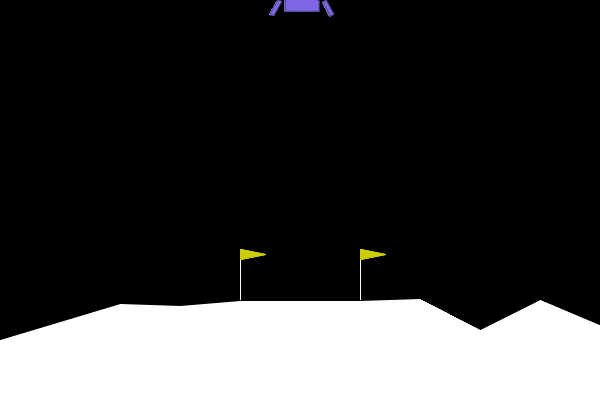

In [6]:
env.reset()
PIL.Image.fromarray(env.render())

In [7]:
state_size = env.observation_space.shape
num_actions = env.action_space.n

print('State Shape:', state_size)
print('Number of actions:', num_actions)

State Shape: (8,)
Number of actions: 4


In [8]:
# Reset the environment and get the initial state.
initial_state = env.reset()

In [9]:
action = 0

next_state,reward,done,info, *rest = env.step(action)

with np.printoptions(formatter={'float': '{:.3f}'.format}):
    print("Initial State:", initial_state)
    print("Action:", action)
    print("Next State:", next_state)
    print("Reward Received:", reward)
    print("Episode Terminated:", done)
    print("Info:", info)

Initial State: (array([-0.005, 1.419, -0.520, 0.353, 0.006, 0.118, 0.000, 0.000],
      dtype=float32), {})
Action: 0
Next State: [-0.010 1.426 -0.520 0.327 0.012 0.117 0.000 0.000]
Reward Received: 0.1439649053857579
Episode Terminated: False
Info: False


In [10]:
q_network = Sequential([
    Input(shape=state_size),
    Dense(64,'relu'),
    Dense(64,'relu'),
    Dense(num_actions,'linear')
])

target_q_network = Sequential([
    Input(shape=state_size),
    Dense(64,'relu'),
    Dense(64,'relu'),
    Dense(num_actions,'linear')
])

optimizer = Adam(learning_rate=ALPHA)

In [25]:
experience = namedtuple('Experience',['state','action','reward','next_state','done'])

In [12]:
def update_target_network(q_network,target_q_network):
    for target_weights,q_weights in zip(target_q_network.weights,q_network.weights):
        target_weights.assign(TAU*q_weights + (1-TAU)*target_weights)

In [13]:
def compute_loss(experiences,gamma,q_network,target_q_network):
    states,actions,rewards,next_states,done_vals = experiences

    max_qsa = tf.reduce_max(target_q_network(next_states),axis=-1)

    y_targets = rewards + gamma*(1-done_vals)*max_qsa

    q_values = q_network(states)
    q_values = tf.gather_nd(q_values,tf.stack([tf.range(q_values.shape[0]),tf.cast(actions, tf.int32)],axis=1))
    
    loss = MSE(y_targets,q_values)

    return loss

In [14]:
@tf.function
def agent_learn(experiences,gamma):
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences,gamma,q_network,target_q_network)
        gradients = tape.gradient(loss,q_network.trainable_variables)

        optimizer.apply_gradients(zip(gradients,q_network.trainable_variables))
        update_target_network(q_network,target_q_network)

In [15]:
def get_action(q_values,epsilon):
    if np.random.rand() > epsilon:
        return np.argmax(q_values.numpy()[0])
    else:
        return np.random.choice(np.arange(4))

In [16]:
def check_update_conditions(t,num_steps_upd,memory_buffer):
    if (t+1)%num_steps_upd==0 and len(memory_buffer) >= MINIBATCH_SIZE:
        return True
    else:
        return False

In [17]:
def get_experiences(memory_buffer):
    experiences = random.sample(memory_buffer, k=MINIBATCH_SIZE)
    states = tf.convert_to_tensor(np.array([e.state for e in experiences if e is not None]),dtype=tf.float32)
    actions = tf.convert_to_tensor(np.array([e.action for e in experiences if e is not None]),dtype=tf.float32)
    rewards = tf.convert_to_tensor(np.array([e.reward for e in experiences if e is not None]), dtype=tf.float32)
    next_states = tf.convert_to_tensor(np.array([e.next_state for e in experiences if e is not None]),dtype=tf.float32)
    done_vals = tf.convert_to_tensor(np.array([e.done for e in experiences if e is not None]).astype(np.uint8),
                                     dtype=tf.float32)
    return (states, actions, rewards, next_states, done_vals)

In [18]:
def get_new_eps(epsilon):
    return max(E_MIN, E_DECAY*epsilon)

In [19]:
import random
MINIBATCH_SIZE = 64   # mini-batch size
TAU = 1e-3            # soft update parameter
E_DECAY = 0.995       # ε decay rate for ε-greedy policy
E_MIN = 0.01  

In [26]:
start = time.time()
num_episodes = 2000
max_num_timesteps = 1000
total_point_history = []

num_p_av = 100    # number of total points to use for averaging
epsilon = 1.0     # initial ε value for ε-greedy policy

memory_buffer = deque(maxlen=MEMORY_SIZE)

target_q_network.set_weights(q_network.get_weights())

for i in range(num_episodes):
    state = env.reset()
    state = state[0]

    total_points = 0

    for j in range(max_num_timesteps):
        state_qn = np.expand_dims(state,axis=0)
        q_values= q_network(state_qn)
        action = get_action(q_values,epsilon)
        
        next_state, reward, done, info, *rest = env.step(action)
        memory_buffer.append(experience(state, action, reward, next_state, done))

        update = check_update_conditions(j, NUM_STEPS_FOR_UPDATE, memory_buffer)

        if update:
            experiences = get_experiences(memory_buffer)
            agent_learn(experiences, GAMMA)
        state = next_state.copy()
        total_points += reward

        if done:
            break

    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])

    epsilon = get_new_eps(epsilon)

    print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")

    # We will consider that the environment is solved if we get an
    # average of 200 points in the last 100 episodes.
    if av_latest_points >= 200.0:
        print(f"\n\nEnvironment solved in {i+1} episodes!")

        # save the model
        q_network.save('lunar_lander_model.h5')
        break
        
tot_time = time.time() - start
print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

Episode 100 | Total point average of the last 100 episodes: -164.13
Episode 200 | Total point average of the last 100 episodes: -116.06
Episode 300 | Total point average of the last 100 episodes: -47.343
Episode 400 | Total point average of the last 100 episodes: -14.21
Episode 500 | Total point average of the last 100 episodes: 52.635
Episode 600 | Total point average of the last 100 episodes: 147.87
Episode 700 | Total point average of the last 100 episodes: 193.12
Episode 704 | Total point average of the last 100 episodes: 197.96

Episode 705 | Total point average of the last 100 episodes: 200.68

Environment solved in 705 episodes!

Total Runtime: 5536.03 s (92.27 min)


In [27]:
def create_video(filename, env, q_network, fps=30):
    with imageio.get_writer(filename, fps=fps) as video:
        done = False
        state = env.reset()
        state = state[0]
        frame = env.render()
        video.append_data(frame)
        while not done:    
            state = np.expand_dims(state, axis=0)
            q_values = q_network(state)
            action = np.argmax(q_values.numpy()[0])
            state, reward, done, info, *rest = env.step(action)
            frame = env.render()
            video.append_data(frame)

In [29]:
import imageio
create_video('lunar_lander.mp4', env, q_network)

NameError: name 'embed_mp4' is not defined